In [1]:
import sys
print(sys.executable)

d:\anaconda\envs\py312\python.exe


In [2]:
import glob, json, os
from PIL import Image
from tqdm import tqdm_notebook
import numpy as np
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

img_paths = glob.glob('./data/ai_challenger_caption_validation_20170910/caption_validation_images_20170910/*.jpg')
img_paths.sort()

img_paths = img_paths[:3000]
img_paths[:2]

['./data/ai_challenger_caption_validation_20170910/caption_validation_images_20170910\\000ca7b1800c44ed2351f9465e7c7daa14304f66.jpg',
 './data/ai_challenger_caption_validation_20170910/caption_validation_images_20170910\\000e1e2b268139e06b6622ea30294cff5b568220.jpg']

In [3]:
validation_annotations = json.load(
    open('./data/ai_challenger_caption_validation_20170910/caption_validation_annotations_20170910.json')
)

validation_annotations[:2]

[{'url': 'http://img5.cache.netease.com/photo/0005/2013-09-25/99LA1FC60B6P0005.jpg',
  'image_id': '3cd32bef87ed98572bac868418521852ac3f6a70.jpg',
  'caption': ['一个双臂抬起的运动员跪在绿茵茵的球场上',
   '一个抬着双臂的运动员跪在足球场上',
   '一个双手握拳的男人跪在绿茵茵的足球场上',
   '一个抬起双手的男人跪在碧绿的球场上',
   '一个双手握拳的运动员跪在平坦的运动场上']},
 {'url': 'http://img.hexun.com/2011-06-09/130363655.jpg',
  'image_id': 'fb36d921dcd9184bdd4659864fe7f3cff47accf5.jpg',
  'caption': ['房间里一个右手放在嘴角的女人和一个戴着眼镜的男人在研究仪器',
   '一个披着长发的女人和一个戴着眼镜的男人站在室内的桌子旁',
   '室内有一个戴着眼镜的男人在向一个抬起右手的女人展示东西',
   '房间里有一个左手放在盒子上的男人在给一个右手食指放在嘴边的女人展示东西',
   '一个右手放在嘴边的女人和一个戴着眼镜的男人站在房间里']}]

In [4]:
validation_annotations_dict = {x['image_id']: x['caption'][0] for x in validation_annotations}
validation_annotations_dict['3cd32bef87ed98572bac868418521852ac3f6a70.jpg']

'一个双臂抬起的运动员跪在绿茵茵的球场上'

In [5]:
img_paths_basenames = [os.path.basename(x) for x in img_paths]
img_captions = [validation_annotations_dict[x] for x in img_paths_basenames]

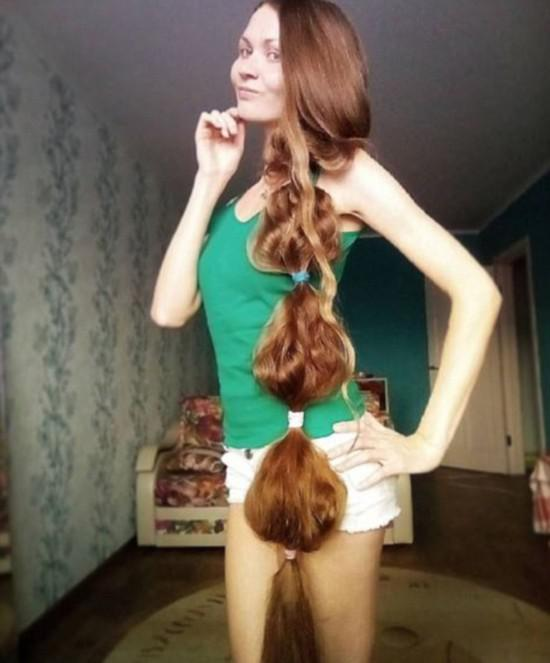

In [6]:
Image.open(img_paths[0])

In [7]:
img_captions[0]

'一个扎着辫子的女人左手叉着腰站在房屋内'

# 加载CLIP模型

In [8]:
from PIL import Image
import requests
from transformers import ChineseCLIPProcessor, ChineseCLIPModel
import torch

model = ChineseCLIPModel.from_pretrained("./models/AI-ModelScope/chinese-clip-vit-base-patch16") # 中文clip模型
processor = ChineseCLIPProcessor.from_pretrained("./models/AI-ModelScope/chinese-clip-vit-base-patch16") # 预处理

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


# 图像编码

In [9]:
img_image_feat = []

batch_size = 20
for idx in tqdm_notebook(range(len(img_captions) // batch_size + 1)):
    imgs = [ Image.open(path) for path in img_paths[idx*batch_size: (idx+1)*batch_size] ]
    
    if len(imgs) == 0:
        break
    
    inputs = processor(images=imgs, return_tensors="pt")
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
        image_features = image_features.data.numpy()
        img_image_feat.append(image_features)

    break  
img_image_feat = np.vstack(img_image_feat)
img_image_feat = normalize(img_image_feat)

C:\Users\PYH\AppData\Local\Temp\ipykernel_27536\365276231.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(range(len(img_captions) // batch_size + 1)):


  0%|          | 0/151 [00:00<?, ?it/s]

In [10]:
img_image_feat.shape # 20张图片 512 维度

(20, 512)

# 文本编码

In [11]:
img_texts_feat = []

batch_size = 20
for idx in tqdm_notebook(range(len(img_captions) // batch_size + 1)):
    texts = [ text for text in img_captions[idx*batch_size: (idx+1)*batch_size] ]

    if len(texts) == 0:
        break
    
    inputs = processor(text=texts, return_tensors="pt", padding=True)

    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        text_features = text_features.data.numpy()
        img_texts_feat.append(text_features)
    break
        
img_texts_feat = np.vstack(img_texts_feat)
img_texts_feat = normalize(img_texts_feat)

C:\Users\PYH\AppData\Local\Temp\ipykernel_27536\3623580869.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(range(len(img_captions) // batch_size + 1)):


  0%|          | 0/151 [00:00<?, ?it/s]

In [12]:
img_texts_feat.shape

(20, 512)

# 尝试1：相似度计算

In [13]:
query_idx = 15

sim_result = np.dot(img_texts_feat[query_idx], img_image_feat.T) # 矩阵计算
sim_idx = sim_result.argsort()[::-1][0:3]
sim_idx,sim_result

(array([15, 19,  9], dtype=int64),
 array([0.18850246, 0.22914465, 0.24592926, 0.19515772, 0.25859585,
        0.21066056, 0.18918957, 0.26688072, 0.22988819, 0.2967123 ,
        0.2575688 , 0.24505246, 0.27383822, 0.27733406, 0.21679161,
        0.36464733, 0.18548283, 0.18768634, 0.29305768, 0.3244386 ],
       dtype=float32))

输入文本:  球场上有两个穿着运动服的男人在打羽毛球


([], [])

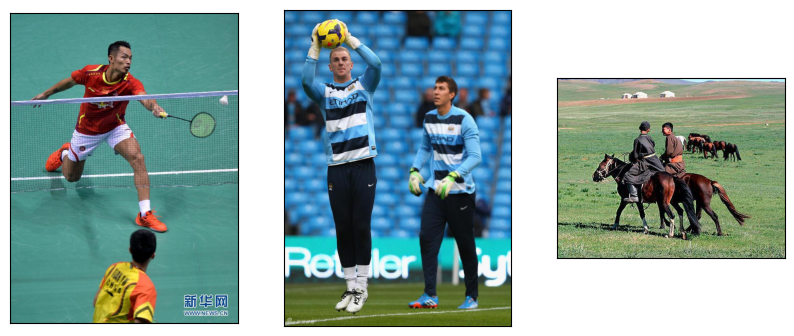

In [14]:
print('输入文本: ', img_captions[query_idx])

plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.imshow(Image.open(img_paths[sim_idx[0]]))
plt.xticks([]); plt.yticks([])

plt.subplot(132)
plt.imshow(Image.open(img_paths[sim_idx[1]]))
plt.xticks([]); plt.yticks([])

plt.subplot(133)
plt.imshow(Image.open(img_paths[sim_idx[2]]))
plt.xticks([]); plt.yticks([])

In [18]:
query_idx = 15

sim_result = np.dot(img_image_feat[query_idx], img_texts_feat.T)
sim_idx = sim_result.argsort()[::-1][0:3]
sim_idx,sim_result

(array([15, 10,  4], dtype=int64),
 array([0.20270073, 0.23714605, 0.21939117, 0.23082893, 0.2678956 ,
        0.20580246, 0.19054464, 0.16602235, 0.16958565, 0.21128556,
        0.290575  , 0.25680813, 0.19065712, 0.26609173, 0.17124593,
        0.36464733, 0.21139975, 0.2122392 , 0.17492768, 0.26148152],
       dtype=float32))

文本识别结果:  ['球场上有两个穿着运动服的男人在打羽毛球', '绚丽的舞台上有一个身前背着吉他的男人在唱歌', '两个穿着运动服的男人在球场上踢足球']


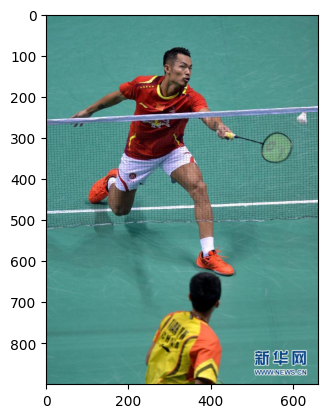

In [17]:
plt.imshow(Image.open(img_paths[query_idx]))

print('文本识别结果: ', [img_captions[x] for x in sim_idx])

# 文本标签编码

In [19]:
import jieba

d:\anaconda\envs\py312\Lib\site-packages\jieba\_compat.py:18: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [20]:
jieba.lcut('今天天气很好，心情也很好。')

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\PYH\AppData\Local\Temp\jieba.cache
Loading model cost 0.429 seconds.
Prefix dict has been built successfully.


['今天天气', '很', '好', '，', '心情', '也', '很', '好', '。']

In [21]:
jieba.lcut(img_captions[0])

['一个', '扎', '着', '辫子', '的', '女人', '左手', '叉', '着', '腰站', '在', '房屋内']

In [22]:
img_captions2words = [jieba.lcut(x) for x in img_captions]
img_captions2words = sum(img_captions2words, [])

In [23]:
img_captions2words[:10]

['一个', '扎', '着', '辫子', '的', '女人', '左手', '叉', '着', '腰站']

In [30]:
img_captions2words = [x for x in img_captions2words if len(x) > 1]
img_captions2words = list(set(img_captions2words))
len(img_captions2words)

1691

In [25]:
img_captions2words[:10]

['裙摆', '文件', '右臂', '板子', '车票', '大厅', '物品', '介绍', '女孩子', '横幅']

In [26]:
img_texts_feat = []

batch_size = 20
for idx in tqdm_notebook(range(len(img_captions2words) // batch_size + 1)):
    texts = [ text for text in img_captions2words[idx*batch_size: (idx+1)*batch_size] ]

    if len(texts) == 0:
        break
    
    inputs = processor(text=texts, return_tensors="pt", padding=True)

    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        text_features = text_features.data.numpy()
        img_texts_feat.append(text_features)
        
img_texts_feat = np.vstack(img_texts_feat)
img_texts_feat = normalize(img_texts_feat)

C:\Users\PYH\AppData\Local\Temp\ipykernel_27536\3640130202.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(range(len(img_captions2words) // batch_size + 1)):


  0%|          | 0/85 [00:00<?, ?it/s]

In [27]:
img_texts_feat.shape

(1691, 512)

# 尝试2：标签相似度计算

In [32]:
query_idx = 15

sim_result = np.dot(img_image_feat[query_idx], img_texts_feat.T)
sim_idx = sim_result.argsort()[::-1][0:6]
sim_idx,sim_result

(array([1195, 1651, 1185, 1320,  808, 1083], dtype=int64),
 array([0.28565514, 0.2545409 , 0.3324915 , ..., 0.25173512, 0.25506455,
        0.260628  ], dtype=float32))

文本识别结果:  ['羽毛球', '抢球', '争球', '打着', '上争', '举到']


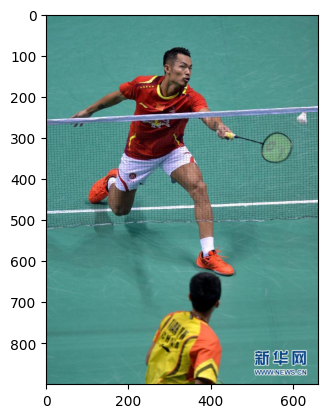

In [33]:
plt.imshow(Image.open(img_paths[query_idx]))

print('文本识别结果: ', [img_captions2words[x] for x in sim_idx])